<a href="https://colab.research.google.com/github/ceydab/NLP_Projects/blob/main/CNN_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning for Natural Language Processing: Sentiment Analysis with CNN

This notebook shows an example of how to use CNN to perform sentiment analysis.
We will use a dataset based on tweets. There are 4 emotions listed in the dataset which allows us to do both binary and multi-class classification.
We will perform two tasks here:
1. Multiclass classfication task
2. Binary classification task


We will import the dataset,

  create functions for tokenization, vectorization, dataloader,

  create CNN class,

  create training function,

  and finally apply the algorithm on both multiclass and binary class sets.

In [1]:
!git clone https://github.com/cardiffnlp/tweeteval.git

fatal: destination path 'tweeteval' already exists and is not an empty directory.


we define the paths, import libraries, define the device, and move onto the functions.

In [2]:
train_path, train_path_labels = "/content/tweeteval/datasets/emotion/train_text.txt", "/content/tweeteval/datasets/emotion/train_labels.txt"
val_path, val_path_labels = "/content/tweeteval/datasets/emotion/val_text.txt", "/content/tweeteval/datasets/emotion/val_labels.txt"
test_path, test_path_labels = "/content/tweeteval/datasets/emotion/test_text.txt", "/content/tweeteval/datasets/emotion/test_labels.txt"
label_path = "tweeteval/datasets/emotion/mapping.txt"

In [3]:
import os
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.utils.data as data
from sklearn.metrics import classification_report
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import string
from transformers import AutoTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Below we create the function for dataframes. Then we observe the labels to decide how to proceed.

For multiclass we will use all 4 labels.

In [5]:
def create_df(path_text, path_label, labels):
  txt = pd.read_csv(path_text, delimiter='\t', header=None, names=["text"])
  label = pd.read_csv(path_label, delimiter='\t', header=None, names=["label"])

  concatenated = pd.concat([txt, label], axis=1, ignore_index=False)
  df = concatenated[concatenated.label.isin(labels)].reset_index(drop=True)
  return df

In [6]:
label_mapping = {}
with open(label_path, 'r') as file:
    for line in file:
        label, emotion = line.strip().split('\t')
        label_mapping[label] = emotion

label_mapping

{'0': 'anger', '1': 'joy', '2': 'optimism', '3': 'sadness'}

In [7]:
labels = [0,1,2,3]
train_df = create_df(train_path, train_path_labels, labels)
val_df = create_df(val_path, val_path_labels, labels)
test_df = create_df(test_path, test_path_labels, labels)
counts = train_df['label'].value_counts()
train_df = train_df.groupby('label').apply(lambda x: x.sample(counts.max(), replace=True)).reset_index(drop=True)

print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())
print(train_df.head())

label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64
label
0    160
1     97
3     89
2     28
Name: count, dtype: int64
label
0    558
3    382
1    358
2    123
Name: count, dtype: int64
                                                text  label
0  “Worry is a down payment on a problem you may ...      2
1  My roommate: it's okay that we can't spell bec...      0
2  No but that's so cute. Atsu was probably shy a...      1
3  Rooneys fucking untouchable isn't he? Been fuc...      0
4  it's pretty depressing when u hit pan on ur fa...      3


After creating the dataframes, we upsample them to balance the imbalance in the dataset.

Next, we have the preprocessing function which we apply to all three dataframes.

In [8]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\x00-\x7F]+', '', text)
  text = text.translate(str.maketrans("","", string.punctuation))
  text = text.strip()
  return text

In [9]:
train_df['text'] = train_df['text'].apply(preprocess)
val_df['text'] = val_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

                                                   text  label
0     why does terrorism exist in the first place as...      0
1     a user not turning up why am i not surprised l...      0
2                                     user bloody right      0
3     user aye theres a brief window in both morning...      0
4                   user ber off ncfc is a grudge match      0
...                                                 ...    ...
5595  light of day per heyday popularization backfir...      3
5596            user u tried boiling em takes years too      3
5597  is this the krusty krabnnno this is crippling ...      3
5598  do you know how much it hurts to see you best ...      3
5599  fellaini has been playing ahead of this guyjus...      3

[5600 rows x 2 columns]
label
0    1400
1    1400
2    1400
3    1400
Name: count, dtype: int64


In [10]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base', use_fast=True, normalization=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


We define a pretrained tokenizer for the model. Below, we balance the text lengths, next, we define the tokenization function, dataloader function, and create dataloaders.

In [11]:
def length_balancer(train_df):
  MAX_LEN = 0
  for tweet in train_df['text']:
      input_ids = tokenizer.encode(tweet, add_special_tokens=True)
      MAX_LEN = max(MAX_LEN, len(input_ids))
  print('Max length Emotion Set: ', MAX_LEN)
  return MAX_LEN, input_ids



In [12]:
def tokenize_text(df, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    for tweet in df['text']:
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            padding = 'max_length',
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(df['label'].values)
    return input_ids, attention_masks, labels

In [13]:
def dataloader(train_df,val_df, test_df):
  MAX_LEN, input_ids = length_balancer(train_df)

  input_ids_train, attention_masks_train, labels_train = tokenize_text(train_df, tokenizer, MAX_LEN)
  input_ids_val, attention_masks_val, labels_val = tokenize_text(val_df, tokenizer, MAX_LEN)
  input_ids_test, attention_masks_test, labels_test = tokenize_text(test_df, tokenizer, MAX_LEN)

  train_dataset = TensorDataset(input_ids_train, labels_train)
  train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = 128)

  val_dataset = TensorDataset(input_ids_val, labels_val)
  val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = 128)

  test_dataset = TensorDataset(input_ids_test, labels_test)
  test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = 128)

  return train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader

In [14]:
train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = dataloader(train_df, val_df, test_df)

Max length Emotion Set:  62


Now, we define our CNN architecture, and training function.

In [15]:
class SentimentCNN(nn.Module):
    def __init__(self,
                 vocab_size=tokenizer.vocab_size,
                 embed_dim=250,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        super(SentimentCNN, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                        embedding_dim=self.embed_dim,
                                        padding_idx=2,
                                        max_norm=3)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.embed_dim,
                                              out_channels=num_filters[i],
                                              kernel_size = filter_sizes[i])
                                    for i in range(len(filter_sizes))
                                    # for filter_size in filter_sizes
                                    ])
        # self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p =dropout)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.num_classes= num_classes

    def forward(self, x):
        embedded = self.embedding(x).float()
        embedded = embedded.permute(0, 2, 1)
        conved = [self.act(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, kernel_size=conv.shape[2]) for conv in conved]
        # conved2 = [self.act(conv(embedded)) for conv in self.convs]
        # pooled2 = [F.max_pool1d(conv, kernel_size=conv.shape[2]) for conv in conved2]
        # cat = self.dropout(torch.cat(pooled, dim=-1))
        cat = self.dropout(torch.cat([x_pool.squeeze(dim=2) for x_pool in pooled],
                         dim=1))
        output = self.fc(cat)
        return output
print(SentimentCNN())

SentimentCNN(
  (embedding): Embedding(50265, 250, padding_idx=2, max_norm=3)
  (convs): ModuleList(
    (0): Conv1d(250, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(250, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(250, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (act): ReLU()
  (sigmoid): Sigmoid()
)


In [42]:
def training(train_dataloader,val_dataloader, test_dataloader,model, loss_fn= nn.CrossEntropyLoss(), eta=0.1, epochs=15, device=device):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = [], [], [], [], [], []
  optimizer = torch.optim.Adam(model.parameters(), lr=eta)
  model = model.to(device)
  loss_fn = loss_fn.to(device)


  for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0.0
    for x,t in train_dataloader:
      optimizer.zero_grad()
      x = x.to(device)
      t = t.to(device)
      train_outputs = model(x)
      if train_outputs.shape[1] == 1:
        loss = loss_fn(train_outputs.squeeze(), t.float())
      else:
        loss = loss_fn(train_outputs, t)
      loss.backward()
      optimizer.step()
      total += t.size(0)
      total_loss += loss.item()*x.size(0)
      _,predicted = torch.max(train_outputs.data,1)
      total_correct += (predicted == t).sum().item()
    train_loss.append(total_loss / total)
    train_acc.append(total_correct / total)

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0.0
    with torch.no_grad():
        for x, t in val_dataloader:
            x = x.to(device)
            t = t.to(device)
            val_outputs = model(x)
            if val_outputs.shape[1] == 1:
              loss = loss_fn(val_outputs.squeeze(), t.float())
            else:
              loss = loss_fn(val_outputs, t)
            total_loss += loss.item() * x.size(0)
            total += t.size(0)
            _, predicted = torch.max(val_outputs.data, 1)
            total_correct += (predicted == t).sum().item()
    val_loss.append(total_loss / total)
    val_acc.append(total_correct / total)



    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0.0
    all_predictions, all_targets = [], []
    with torch.no_grad():
      for x,t in test_dataloader:
        x = x.to(device)
        t = t.to(device)
        test_outputs = model(x)
        if test_outputs.shape[1] == 1:
          loss = loss_fn(test_outputs.squeeze(), t.float())
        else:
          loss = loss_fn(test_outputs, t)
        total_loss += loss.item()*x.size(0)
        total += t.size(0)
        _,predicted = torch.max(test_outputs.data,1)
        total_correct += (predicted == t).sum().item()
        all_predictions += predicted.cpu().numpy().tolist()
        all_targets += t.cpu().numpy().tolist()

    test_loss.append(total_loss / total)
    test_acc.append(total_correct / total)
    if train_outputs.shape[1] == 1 or train_outputs.shape[1]==2:
        test_report = classification_report(all_targets, all_predictions, target_names=['neg', 'pos'])
    else:
        test_report = classification_report(all_targets, all_predictions, target_names=['anger', 'fear', 'joy', 'sadness'])

    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f},Validation Loss: {val_loss[-1]:.4f}, Validation Acc: {val_acc[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")


  return train_loss, train_acc, val_loss,val_acc, test_loss, test_acc, test_report

Let's define the model for multiple classification, call the training function, print the classification report for test, and plot loss and accuracies.

In [17]:
model_multi = SentimentCNN(embed_dim =256, num_filters=[64,64,64], filter_sizes = [3,4,5], num_classes=4, dropout=0.3)

In [18]:
train_loss, train_acc,val_loss,val_acc,  test_loss, test_acc, test_report = training(train_dataloader, val_dataloader, test_dataloader,  loss_fn=nn.CrossEntropyLoss(), model=model_multi, eta=0.0005, epochs=15)
print(f"Test Classification Report:\n{test_report}")

Epoch 1, Train Loss: 1.3288, Train Acc: 0.4380,Validation Loss: 1.3632, Validation Acc: 0.3155, Test Loss: 1.3598, Test Acc: 0.3399
Epoch 2, Train Loss: 1.1516, Train Acc: 0.7182,Validation Loss: 1.3052, Validation Acc: 0.4225, Test Loss: 1.2941, Test Acc: 0.4462
Epoch 3, Train Loss: 0.9209, Train Acc: 0.8275,Validation Loss: 1.2222, Validation Acc: 0.5080, Test Loss: 1.1956, Test Acc: 0.5151
Epoch 4, Train Loss: 0.6544, Train Acc: 0.8957,Validation Loss: 1.1355, Validation Acc: 0.5401, Test Loss: 1.0936, Test Acc: 0.5595
Epoch 5, Train Loss: 0.4276, Train Acc: 0.9389,Validation Loss: 1.0649, Validation Acc: 0.5749, Test Loss: 1.0086, Test Acc: 0.5954
Epoch 6, Train Loss: 0.2648, Train Acc: 0.9671,Validation Loss: 1.0198, Validation Acc: 0.5856, Test Loss: 0.9486, Test Acc: 0.6144
Epoch 7, Train Loss: 0.1711, Train Acc: 0.9812,Validation Loss: 0.9957, Validation Acc: 0.5882, Test Loss: 0.9168, Test Acc: 0.6263
Epoch 8, Train Loss: 0.1150, Train Acc: 0.9866,Validation Loss: 0.9936, Vali

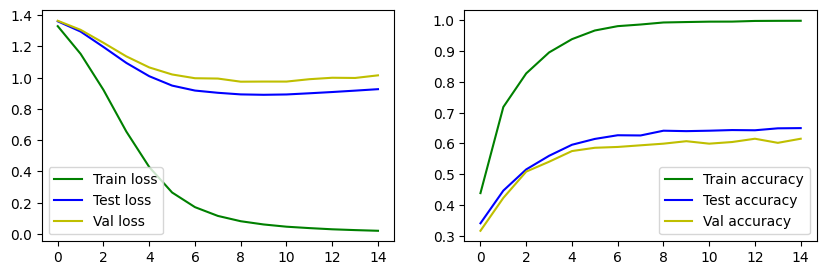

In [24]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(train_loss, "g-", label="Train loss")
ax.plot(test_loss, "b-", label="Test loss")
ax.plot(val_loss, "y-", label = "Val loss")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(train_acc, "g-", label="Train accuracy")
ax.plot(test_acc, "b-", label="Test accuracy")
ax.plot(val_acc, "y-", label = "Val accuracy")
ax.legend()

While accuracy and other metrics don't seem to be too low, the model seems to be overfitting as the loss don't converge for validation and test. There might be several reasons for this such as dataset imbalance (though we have applied upsampling), the similarities of vocabulary used for the expression of the emotions, limited success in feature engineering.


Now, we will switch to binary classification. First, we will group the labels as negative and positive emotions, apply the loader, define the model, call the training and print the results.

In [43]:
# New label mapping
new_label_mapping = {'0': 0, '1': 1, '2': 0, '3': 1}

# Update labels in dataframes
train_df['label'] = train_df['label'].apply(lambda x: new_label_mapping[str(x)])
val_df['label']= val_df['label'].apply(lambda x: new_label_mapping[str(x)])
test_df['label'] = test_df['label'].apply(lambda x: new_label_mapping[str(x)])

# Check the updated label distributions
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())


label
0    2800
1    2800
Name: count, dtype: int64
label
0    188
1    186
Name: count, dtype: int64
label
1    740
0    681
Name: count, dtype: int64


In [44]:
train_dataset,val_dataset, test_dataset, train_dataloader,val_dataloader, test_dataloader = dataloader(train_df,val_df, test_df)

Max length Emotion Set:  62


In [81]:
model_binary = SentimentCNN(embed_dim =128, num_filters=[64,64,64], filter_sizes = [3,4,5], num_classes=2, dropout=0.5)

In [82]:
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, test_report = training(train_dataloader, val_dataloader, test_dataloader,  loss_fn=nn.CrossEntropyLoss(), model=model_binary, eta=0.0003, epochs=10)
print(test_report)

Epoch 1, Train Loss: 0.6803, Train Acc: 0.5618,Validation Loss: 0.6868, Validation Acc: 0.5535, Test Loss: 0.6850, Test Acc: 0.5721
Epoch 2, Train Loss: 0.6351, Train Acc: 0.6766,Validation Loss: 0.6779, Validation Acc: 0.5829, Test Loss: 0.6739, Test Acc: 0.6137
Epoch 3, Train Loss: 0.5850, Train Acc: 0.7630,Validation Loss: 0.6679, Validation Acc: 0.6123, Test Loss: 0.6629, Test Acc: 0.6235
Epoch 4, Train Loss: 0.5196, Train Acc: 0.8266,Validation Loss: 0.6540, Validation Acc: 0.6497, Test Loss: 0.6458, Test Acc: 0.6460
Epoch 5, Train Loss: 0.4532, Train Acc: 0.8552,Validation Loss: 0.6381, Validation Acc: 0.6390, Test Loss: 0.6260, Test Acc: 0.6721
Epoch 6, Train Loss: 0.3784, Train Acc: 0.8929,Validation Loss: 0.6226, Validation Acc: 0.6497, Test Loss: 0.6050, Test Acc: 0.6861
Epoch 7, Train Loss: 0.3049, Train Acc: 0.9223,Validation Loss: 0.6069, Validation Acc: 0.6711, Test Loss: 0.5835, Test Acc: 0.7065
Epoch 8, Train Loss: 0.2498, Train Acc: 0.9402,Validation Loss: 0.5912, Vali

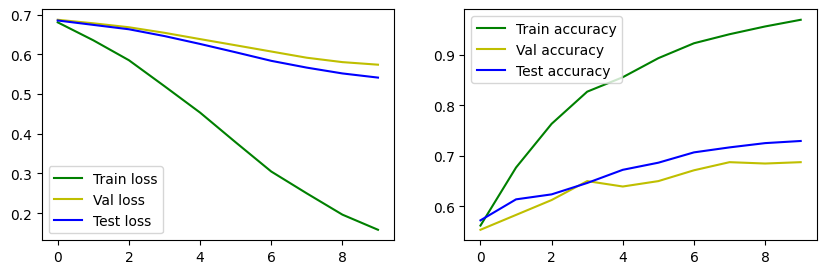

In [83]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(train_loss, "g-", label="Train loss")
ax.plot(val_loss, "y-", label="Val loss")
ax.plot(test_loss, "b-", label="Test loss")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(train_acc, "g-", label="Train accuracy")
ax.plot(val_acc, "y-", label="Val accuracy")
ax.plot(test_acc, "b-", label="Test accuracy")
ax.legend()

We observe a similar issue for binary class as we have observed for multi class. Since now we have opposing labels but the same issue persists, the problem likely lies in feature engineering and/or limited features.
